Note: This notebook gathers heavily from Lesson 4 of Cutting Edge Deep Learning for Coders: 2018 Edition by Jeremy Howard. I took that notebook and modified it as little as possible to fit the objective of making a Spanish Language Model Classifier.

The task is to classify tweets into one of the following three categories: Positive, Neutral, Negative or None.
For more info: http://www.sepln.org/workshops/tass/2018/task-1/

In [2]:
import sys
sys.path.append("../..")
from fastai.text import *
import html
import json

In [3]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

DATA_PATH=Path('../datasets')

OUTPUT_PATH=Path('../output')

WIKILM_PATH=OUTPUT_PATH/'wiki_lm'

TASSLM_PATH=OUTPUT_PATH/'tass_lm'

CLAS_PATH=OUTPUT_PATH/'tass_clas'

In [4]:
%%javascript
// Original source -- https://gist.github.com/xem/670dec8e70815842eb95
Jupyter.beep = () => {
    var A=new AudioContext();
    var o = A.createOscillator();
    o.connect(A.destination);
    o.start(0);
    var duration = 500;
    setTimeout(function(){o.stop(); A.close();}, duration);
}

<IPython.core.display.Javascript object>

## Pre-Process TASS Dataset

Load GeneralTASS Corpus Dataset

In [49]:
import xml.etree.ElementTree as ET

TASS_DATA_PATH = Path(DATA_PATH/'generalTASS')
TRN_PATH = TASS_DATA_PATH/'trn'

BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

In [50]:
e = ET.parse(TRN_PATH/'general-train-tagged-3l.xml')
root = e.getroot()

Check how big our dataset is

In [51]:
print(len(np.array([tweet.find('content').text for tweet in root.findall('tweet')])))

7219


Separate tweets, labels and types into arrays

In [52]:
tweets = np.array([tweet.find('content').text for tweet in root.findall('tweet')])
labels = np.array([tweet.find('sentiments').find('polarity').find('value').text for tweet in root.findall('tweet')])
types = np.array([tweet.find('sentiments').find('polarity').find('type').text for tweet in root.findall('tweet')])

Labels to integers

In [53]:
LABELS = set(labels)
list(LABELS)

['P', 'NONE', 'N', 'NEU']

In [54]:
labels_dict = {}
labels_dict['P'] = 0
labels_dict['N'] = 1
labels_dict['NEU'] = 2
labels_dict['NONE'] = 3
print(labels_dict)

{'P': 0, 'N': 1, 'NEU': 2, 'NONE': 3}


In [55]:
labels = [labels_dict[i] for i in labels]

Some standard pre-processing: We delete all None type tweets, we replace some tokens with more meaningful ones and we shuffle tokens randomly

In [56]:
none_ind = [ind for ind, tweet in enumerate(tweets) if tweet is None]

tweets = np.delete(tweets, none_ind, 0)
labels = np.delete(labels, none_ind, 0)
types = np.delete(types, none_ind, 0)

In [57]:
def flattern(A):
    'Source: https://stackoverflow.com/a/17867797/7273299'
    
    'Flattens a list of lists and strings into a list.'
    rt = []
    for i in A:
        if isinstance(i,list): rt.extend(flattern(i))
        else: rt.append(i)
    return rt

In [58]:
# Placeholders for hyperlinks and user references
tweets = [['hyp_link' if i.startswith('http://t.co') else 'user_ref' if i.startswith('@') else i for i in tweet.split()] for tweet in tweets]
tweets = np.array([' '.join(i) for i in tweets])

In [59]:
# Prefix for Hashtags
tweets = [[['hash_tag', i] if i.startswith('#') else i for i in tweet.split()] for tweet in tweets]
tweets = np.array([flattern(tweet) for tweet in tweets])
tweets = np.array([' '.join(i) for i in tweets])

In [60]:
def isInt(v):
    'Source: https://stackoverflow.com/a/9859202/7273299'
    
    'Checks if a string is a number.'
    try:     i = int(v)
    except:  return False
    return True

In [61]:
# Prefix for integers
tweets = [[['int_string', i] if isInt(i) else i for i in tweet.split()] for tweet in tweets]
tweets = np.array([flattern(tweet) for tweet in tweets])
tweets = np.array([' '.join(i) for i in tweets])

In [62]:
# Prefix for slang
tweets = [[['que', 'slang_string'] if i=='q' else ['por', 'slang_string'] if i=='x' else ['de', 'slang_string'] if i=='d' else ['Que', 'slang_string'] if i=='Q' else ['Por', 'slang_string'] if i=='X' else ['De', 'slang_string'] if i=='D' else i for i in tweet.split()] for tweet in tweets]
tweets = np.array([flattern(tweet) for tweet in tweets])
tweets = np.array([' '.join(i) for i in tweets])

In [63]:
def char_count(word, chars, lbound=2):
    char_count = [word.count(char) for char in chars]
    return all(i >= lbound for i in char_count)

def replace_lol(repl_str, texts):
    for string, chars in repl_str:
        texts = [[[string, i] if char_count(i, set(chars), 2) else i for i in text.split()] for text in texts]
        texts = np.array([flattern(text) for text in texts])
        texts = np.array([' '.join(text) for text in texts])
    return texts

In [64]:
# Lol type characters
repl_str = [('risa_ja','ja'), ('risa_ji','ji'), ('risa_je','je'), ('risa_jo','jo'), ('risa_ju', 'ju')]

# Adding prefix to lol type characters
tweets = replace_lol(repl_str, tweets)

In [65]:
np.random.seed(42)

trn_idx = np.random.permutation(len(tweets))

tweets = tweets[trn_idx]
labels = labels[trn_idx]
types = types[trn_idx]

In [66]:
col_names = ['label', 'tweet']

In [67]:
print(tweets[:15])

['user_ref ya nos contarás si explota Europa (como dice Sarkozy)'
 'risa_ja Jajajajajja la mierda del nuevo twitter locooooo me tiene......'
 '"el mejor método de educación es la felicidad...para sufrir, la vida es más que suficiente y yo no le voy a ayudar"'
 'Rajoy viaja en AVE para dar su primer discurso publico, en un mitin en Málaga. Un gesto: no va en el avión de presidente, sino en tren.'
 'RT user_ref Sr. Mas, no garantizar una sanidad publica de calidad universal es anticonstitucional ,por eso no celebra dia constitucion?'
 'Andalucía está comprometida con la estabilidad, pero exigimos lealtad institucional. No discriminar a CCAA por color político hash_tag #debateAND'
 'user_ref user_ref perdona, señor Raul.'
 'Guerra de encuestas! Canal Sur no da la mayoría absoluta al PP, y otras sí.'
 'RT user_ref user_ref charlando con el futbolista Fernando Morientes en hash_tag #Guadalajara, Gala del Deporte hash_tag #CLM hyp_link'
 'A las 11:30 estaré en directo con Carlos Herrera, par

Build validation and training sets

In [68]:
train_limit = int(len(tweets)*0.8)
val_limit = int(len(tweets)*0.9)

In [69]:
df_trn = pd.DataFrame({'tweet':tweets[:train_limit], 'label':labels[:train_limit]}, columns=col_names)
df_val = pd.DataFrame({'tweet':tweets[train_limit:val_limit], 'label':labels[train_limit:val_limit]}, columns=col_names)
df_tst = pd.DataFrame({'tweet':tweets[val_limit:], 'label':labels[val_limit:]}, columns=col_names)

In [70]:
df_trn.head(15)

,label,tweet
0,1,user_ref ya nos contarás si explota Europa (co...
1,1,risa_ja Jajajajajja la mierda del nuevo twitte...
2,2,"""el mejor método de educación es la felicidad...."
3,0,Rajoy viaja en AVE para dar su primer discurso...
4,1,"RT user_ref Sr. Mas, no garantizar una sanidad..."
5,0,Andalucía está comprometida con la estabilidad...
6,2,"user_ref user_ref perdona, señor Raul."
7,2,Guerra de encuestas! Canal Sur no da la mayorí...
8,3,RT user_ref user_ref charlando con el futbolis...
9,3,A las 11:30 estaré en directo con Carlos Herre...


The pandas dataframe is used to store text data in a newly evolving standard format of label followed by text columns. This was influenced by a paper by Yann LeCun (LINK REQUIRED). Fastai adopts this new format for NLP datasets. In the case of IMDB, there is only one text column.

In [71]:
df_trn[df_trn['label']!=3].to_csv(CLAS_PATH/'train.csv', header=False, index=False)
df_val[df_val['label']!=3].to_csv(CLAS_PATH/'validation.csv', header=False, index=False)
df_tst[df_tst['label']!=3].to_csv(CLAS_PATH/'test.csv', header=False, index=False)

(CLAS_PATH/'classes.txt').open('w').writelines(f'{o}\n' for o in LABELS)

In [72]:
df_trn = pd.DataFrame({'tweet':tweets[:train_limit], 'label':[0]*len(labels[:train_limit])}, columns=col_names)
df_val = pd.DataFrame({'tweet':tweets[train_limit:val_limit], 'label':[0]*len(labels[train_limit:val_limit])}, columns=col_names)
df_tst = pd.DataFrame({'tweet':tweets[val_limit:], 'label':[0]*len(labels[val_limit:])}, columns=col_names)

In [73]:
df_trn.to_csv(TASSLM_PATH/'train.csv', header=False, index=False)
df_val.to_csv(TASSLM_PATH/'validation.csv', header=False, index=False)
df_tst.to_csv(TASSLM_PATH/'test.csv', header=False, index=False)

## Tokenize and Standarize General Tokens for TASS Dataset

#TODO: use fast ai functions

Pre-processing using fast.ai functions

In [5]:
chunksize=24000

re1 = re.compile(r'  +')

In [6]:
def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = texts.apply(fixup).values.astype(str)

    tok = Tokenizer(lang='es').proc_all_mp(partition_by_cores(texts), lang='es')
    return tok, list(labels)

def get_all(df, n_lbls):
    tok, labels = [], []
#     print(df)
    for i, r in enumerate(df):
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [98]:
df_trn = pd.read_csv(TASSLM_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(TASSLM_PATH/'validation.csv', header=None, chunksize=chunksize)

In [99]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

In [100]:
print(tok_trn[:2])

[['\n', 'xbos', 'user_ref', 'ya', 'nos', 'contarás', 'si', 'explota', 'europa', '(', 'como', 'dice', 'sarkozy', ')'], ['\n', 'xbos', 'risa_ja', 'jajajajajja', 'la', 'mierda', 'del', 'nuevo', 'twitter', 'loc', 'tk_rep', '5', 'o', 'me', 'tiene', 'tk_rep', '6', '.']]


In [101]:
(TASSLM_PATH/'tmp').mkdir(exist_ok=True)

In [102]:

np.save(TASSLM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(TASSLM_PATH/'tmp'/'tok_val.npy', tok_val)

In [103]:
tok_trn = np.load(TASSLM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(TASSLM_PATH/'tmp'/'tok_val.npy')

In [104]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(20)

[('\n', 5774),
 ('xbos', 5774),
 ('de', 4683),
 ('.', 3719),
 ('la', 2944),
 ('user_ref', 2760),
 ('el', 2711),
 (',', 2615),
 ('en', 2491),
 ('a', 2246),
 ('que', 2243),
 ('hyp_link', 2052),
 ('y', 1987),
 ('!', 1982),
 ('#', 1417),
 ('"', 1393),
 ('hash_tag', 1357),
 ('t_up', 1283),
 (':', 1229),
 ('los', 1111)]

In [105]:
max_vocab = 60000
min_freq = 2

In [106]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

3654

In [107]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [108]:
np.save(TASSLM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(TASSLM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(TASSLM_PATH/'tmp'/'itos.pkl', 'wb'))

In [109]:
%%javascript
Jupyter.beep();

<IPython.core.display.Javascript object>

## Load Encoder Weights for Language Model

In [4]:
BACKBONE_MODEL = WIKILM_PATH/'models+100/lm1_weights_kl.h5'

In [5]:
wgts = torch.load(BACKBONE_MODEL, map_location=lambda storage, loc: storage)

We calculate the mean of the layer0 encoder weights. This can be used to assign weights to unknown tokens when we transfer to target IMDB LM.

In [6]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [7]:
itos2 = pickle.load((WIKILM_PATH/'tmp+100'/'itos+100.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

Before we try to transfer the knowledge from wikitext to the IMDB LM, we match up the vocab words and their indexes. We use the defaultdict container once again, to assign mean weights to unknown IMDB tokens that do not exist in wikitext103.

In [8]:
em_sz,nh,nl = 400,1150,3

In [9]:
trn_lm = np.load(TASSLM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(TASSLM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(TASSLM_PATH/'tmp'/'itos.pkl', 'rb'))

In [10]:
vs=len(itos)
vs,len(trn_lm)

(3654, 5774)

In [11]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

"We now overwrite the weights into the wgts odict. The decoder module, which we will explore in detail is also loaded with the same weights due to an idea called weight tying."

In [12]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

## Language Model Finetuning

In [13]:
wd=1e-7
bptt=70
bs=64
em_sz,nh,nl = 400,1150,3
opt_fn = partial(optim.SGD, momentum=0.9)

In [14]:
trn_lm = np.load(TASSLM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(TASSLM_PATH/'tmp'/'val_ids.npy')
trn_lm = np.concatenate(trn_lm)
val_lm = np.concatenate(val_lm)

In [15]:
itos = pickle.load(open(TASSLM_PATH/'tmp'/'itos.pkl', 'rb'))
vs = len(itos)

trn_dl = LanguageModelLoader(trn_lm, bs, bptt)
val_dl = LanguageModelLoader(val_lm, bs, bptt)
md = LanguageModelData(TASSLM_PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [16]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

In [17]:
learn = md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learn.metrics = [accuracy]
learn.unfreeze()

In [18]:
learn.model.load_state_dict(wgts)

In [19]:
learn.lr_find2(start_lr=1e-1,end_lr=30, num_it=300)

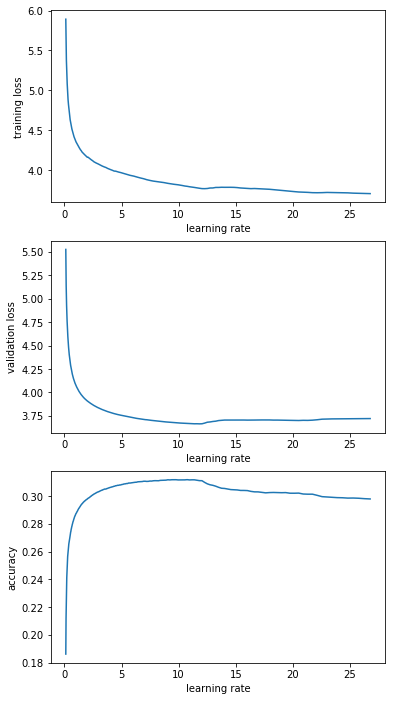

In [20]:
learn.sched.plot()

In [21]:
lr=10
lrs = lr

In [22]:
learn.clip=0.12

In [23]:
learn.fit(lr, 1, cycle_len=10, use_clr_beta=(10,33,0.95,0.85), best_save_name='lm1_wgts')

epoch      trn_loss   val_loss   accuracy                 
    0      4.853143   3.974472   0.288784  
    1      4.339055   3.731294   0.297303                 
    2      4.065951   3.656287   0.305585                 
    3      3.859634   3.580975   0.316899                 
    4      3.701328   3.558885   0.314969                 
    5      3.558439   3.542998   0.31929                  
    6      3.437419   3.539674   0.322704                 
    7      3.340056   3.527992   0.325185                 
    8      3.278157   3.538889   0.322388                 
    9      3.234205   3.536332   0.323139                 


[array([3.53633]), 0.32313938438892365]

In [24]:
learn.load('lm1_wgts')
learn.save_encoder('lm1_enc')

In [25]:
%%javascript
Jupyter.beep();

<IPython.core.display.Javascript object>

## Classifier tokens

In [7]:
chunksize=24000

re1 = re.compile(r'  +')

In [8]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None, chunksize=chunksize)
df_tst = pd.read_csv(CLAS_PATH/'validation.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/'test.csv', header=None, chunksize=chunksize)

In [9]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)
tok_tst, tst_labels = get_all(df_tst, 1)

In [10]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

In [11]:
np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)
np.save(CLAS_PATH/'tmp'/'tok_tst.npy', tok_tst)

In [12]:
np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)
np.save(CLAS_PATH/'tmp'/'tst_labels.npy', tst_labels)

In [13]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')
tok_tst = np.load(CLAS_PATH/'tmp'/'tok_tst.npy')

In [14]:
itos = pickle.load((TASSLM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

3654

In [15]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])
tst_clas = np.array([[stoi[o] for o in p] for p in tok_tst])

In [16]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)
np.save(CLAS_PATH/'tmp'/'tst_ids.npy', tst_clas)

## Classifier

Parameters here were obtained from imdb notebook from fastai

In [212]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

In [213]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

In [214]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 48

In [215]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In the classifier, unlike LM, we need to read a movie review at a time and learn to predict the it's sentiment as pos/neg. We do not deal with equal bptt size batches, so we have to pad the sequences to the same length in each batch. To create batches of similar sized movie reviews, we use a sortish sampler method invented by [@Smerity](https://twitter.com/Smerity) and [@jekbradbury](https://twitter.com/jekbradbury)

The sortishSampler cuts down the overall number of padding tokens the classifier ends up seeing.

In [216]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(TASSLM_PATH, trn_dl, val_dl)

In [217]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.8

In [218]:
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [219]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [220]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=.12
learn.metrics = [accuracy]

In [221]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [222]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [223]:
#wd = 1e-7
learn.load_encoder('lm1_enc')

In [224]:
learn.freeze_to(-1)

In [86]:
learn.lr_find2(start_lr=1e-3,end_lr=1, num_it=300)
learn.sched.plot()

 31%|███       | 59/191 [00:02<00:05, 25.36it/s, loss=0.945]


KeyboardInterrupt: 

In [225]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr_beta=(32,10,0.8,0.7))

epoch      trn_loss   val_loss   accuracy                    
    0      0.835816   0.783861   0.662162  



[array([0.78386]), 0.6621621686059076]

In [226]:
learn.save('clas2_0')

In [227]:
learn.load('clas2_0')

In [228]:
learn.freeze_to(-2)

In [229]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr_beta=(32,10,0.8,0.7))

epoch      trn_loss   val_loss   accuracy                    
    0      0.820709   0.76136    0.680743  



[array([0.76136]), 0.6807432416323069]

In [230]:
learn.save('clas2_1')

In [231]:
learn.load('clas2_1')

In [232]:
learn.unfreeze()

In [233]:
learn.fit(lr, 1, cycle_len=5, use_clr_beta=(32,10,0.8,0.7), best_save_name='clas2')

epoch      trn_loss   val_loss   accuracy                    
    0      0.772346   0.721024   0.690878  
    1      0.720853   0.69419    0.706081                    
    2      0.68693    0.721213   0.702703                    
    3      0.609139   0.748159   0.711149                    
    4      0.504883   0.746539   0.711149                    



[array([0.74654]), 0.7111486405939669]

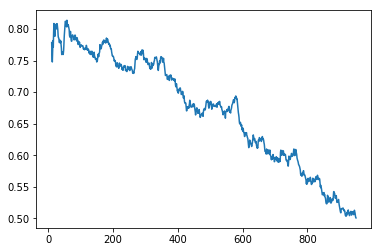

In [234]:
learn.sched.plot_loss()

The previous state of the art result was 70% accuracy (30% error).

## Check F1 score

We load the model with the corresponding weights and parameters

In [235]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=.12
learn.metrics = [accuracy]

We perform predictions on each of the val_sets texts as per [Matthias Bachfischer's script](https://github.com/Bachfischer/german2vec/blob/master/src/sb-10k-use_pretrained_language_model.ipynb)

In [239]:
# load test set tokens
tok_tst= np.load(CLAS_PATH/'tmp'/'tok_tst.npy')

# load classification model weights
learn.load('clas2')
m = learn.model

# set batch size to 1
m[0].bs=1

i = 0
results = []
while i < len(tok_tst):
    sen = ' '.join(tok_tst[i])
    i+=1
    m.eval()
    # reset hidden state
    m.reset()
    idxs = np.array([[stoi[p] for p in sen.strip().split(" ")]])
    idxs = np.transpose(idxs)
    # get predictions from model
    p = m(VV(idxs))
    print(sen + ': ' + str(to_np(torch.topk(p[0],1)[1])[0]))
    # append classification to list of results for validation
    results.append(torch.topk(p[0],1)[1].data.tolist()[0])


 xbos gracias , gracias , gracias a todos cuantos habéis seguido confiando en nuestro camino . ahora toca seguir trabajando por andalucia .: [0]

 xbos buenos días , ¡ domingo de resurrección ! buen día para decidir seguir a jesús , el único que puede salvar de tus pecados .: [0]

 xbos ojalá que int_string 2012 sea el año de la erradicación de otra clase de terrorismo , el de la violencia machista hash_tag # mensajegriñan: [1]

 xbos t_up csif se felicita de que slang_string sólo les hayan congelado ; el gob cat , molesto por slang_string quedarse sólo . lo comentamos user_ref en user_ref 20:30: [1]

 xbos en un pueblo de valencia agreden a periodistas por grabar tradición de lanzar ratas hyp_link . ( via user_ref ): [1]

 xbos hash_tag # gallardón : la policía ha actuado obligada por slang_string violencia provocada.desde que slang_string es ministro se ha quitado careta ideológica hyp_link: [1]

 xbos con una ley de transparencia como pide user_ref esto no habría pasado : valencia 


 xbos amaiur no cumple los requisitos y no tendrá grupo parlamentario: [1]

 xbos rubalcaba pide " una subida de impuestos selectiva " , a quienes más tienen y a grandes empresas hash_tag # investidura: [1]

 xbos la ducha escocesa en que slang_string se mueve nuestra economía ( optimismo / pesimismo ) puede durar mucho tiempo . momento de slang_string dudas y signos contradictorios .: [1]

 xbos se recomienda a rosa díez foniatra al canto , con ese tono de voz le van a salir unos pólipos como monaguillos si no se cuida .: [0]

 xbos esas empresas " modelo " ? rt user_ref google , apple y microsoft pagan impuestos mínimos fuera de ee uu hyp_link vía user_ref: [1]

 xbos bueno , resfriados estamos muchos .. pero a coruña es bella incluso estando gris . rt user_ref ( cont ) hyp_link: [0]

 xbos la audiencia vuelve a imputar a bárcenas , merino y galeote . veamos si cospedal es tan buena arquitecta como trillo con la justicia .: [2]

 xbos tk_wrep 5 user_ref buenas noches ;-) ) a ver si 


 xbos y la igualdad de hash_tag # oportunidades para conseguir mejorar los niveles educativos de la hash_tag # comunidad autónoma: [0]

 xbos covergència , después de su congreso , ha marcado claro su objetivo : llevar a cataluña al conflicto social desde la insumisión de slang_string coche oficial: [0]

 xbos un buen trabajo ... “@lavanguardia : la t_up nasa busca astronautas para ir a un asteroide hyp_link: [0]

 xbos no , el jefe de prensa de morenés no soy risa_ja yo , jaja .: [1]

 xbos en sevilla ratificaremos nuestra condición de slang_string lideres y mañana neymar nos hara disfrutar mucho: [0]

 xbos una lástima no poder estar el 4 / 2 en la de despedida de palermo . justo homenaje para alguien que slang_string se merece todo hyp_link: [0]

 xbos la cuesta de enero es la crisis deluxe .: [1]

 xbos vamos a empezar bien ... a desayunar: [0]

 xbos rajoy acaba de negar que la comisión le haya apremiado a presentar los presupuestos . barroso , preguntado al respecto , ha eludido


 xbos rt user_ref ya nos sigues , nos haces rt si puedes t_up dona es tan fácil como unos cuantos click . opciones : hyp_link ayuda hash_tag # cuer ...: [0]

 xbos que bien esta user_ref en el user_ref enhorabuena pelirroja !: [0]

 xbos encantada de empezar el año con muchos más amigos . gracias ! ! :): [0]

 xbos título de la obra : " inspiración asiática o como quedarse sin tinta en el bic " ;-) hyp_link: [0]

 xbos gracias goyi “ @goyi_64 : muchas felicidades , presidente . que con salud cumpla muchos más ”: [0]

 xbos chacón sobre los derechos de la mujer : " con zapatero hemos dado más pasos que nunca en la historia de la humanidad " .: [2]

 xbos nunca discutas con un idiota , la gente podría no notar la diferencia . kant ( via user_ref ): [1]

 xbos rt user_ref conmemoramos el bicentenario de la constitución de slang_string cádiz.martes 20(19:30h)en casal pere quart de slang_string hash_tag # sabadell con user_ref: [0]

 xbos de dónde saldrá el dinero para el banco malo de raj


 xbos el fracaso de los fondos mineros está en la falta de slang_string voluntad del gobierno central y en nuestra incapacidad de slang_string diseñar su futuro en asturias: [1]

 xbos huauchinango ! gracias por slang_string hacerme sentir tan querida 15.001 almas cantando juntas debajo de slang_string la lluvia tk_rep 5 ! conciertazo ! !: [0]

 xbos me voy a la concentración en el supremo . por la memoria y la justicia para todas las víctimas . contra la corrupción . por garzón .: [0]

 xbos la tramitación de la enésima contrarreforma laboral como real decreto es un desastre , pero todavía puede empeorar .: [1]

 xbos la junta de andalucia solo ha ejecutado el 4 % de las t_up vpo prometidas desde int_string 2008 hyp_link: [1]

 xbos si , si cosido es palentino . este teléfono escribe palabras solo ! a veces ( soy negada ) hahahahahaha: [1]

 xbos rajoy a rubalcaba : & ' hay que tomar más medidas y no tendrán efecto inmediato & ': [2]

 xbos rt user_ref los fotógrafos desafían a la ce


 xbos uy ! rt user_ref ante las medidas de rajoy , el hash_tag # t_up 25 m elige a alguien que te defienda , que no trague con todo . hyp_link: [0]

 xbos fijo que slang_string hay más ... “ @mmremiro : la juez cifra en int_string 887 las ayudas ' injustas ' para altos cargos del t_up psoe o de la junta hyp_link: [1]

 xbos mi calefacción se ha tomado en serio lo de hash_tag # twitterblackout y se niega a funcionar ... # siempreenfindesemana # siemprecuandollegalaoladefrio: [1]

 xbos soraya rodriguez , t_up psoe " votaremos que sí a la reforma del sistema financiero porque queremos hacer oposición útil " hash_tag # congreso: [0]

 xbos mañana pregunto al gobierno sobre la involucion laboral . fraude y expolio para expropiar las rentas salariales .: [1]

 xbos os pedimos vuestra confianza para un proyecto ilusionante que revolucionará andalucía y la convertirá en referencia en españa y europa .: [0]

 xbos es espectacular , tanto tiempo preparando cada detalle , y por fin lo podréis e


 xbos acusaban al pp de crispar y ahora escriben cosas así ... flipo . para sobrevivir hacen falta estos excesos ? hyp_link: [0]

 xbos ¡ lo mejor de mi timeline está disponible ! hyp_link ▸ historias del día por user_ref user_ref user_ref user_ref: [0]

 xbos “ @paquivicente : hola user_ref me haces un rt para encontrar el perro de user_ref en la foto está la info ! hyp_link: [0]

 xbos últimamenteaa rt user_ref user_ref últimamente dice usted unas cosas muy extrañas ...: [0]

 xbos la producción industrial subió en noviembre un 15,8 % respecto al mismo mes del año anterior ... la + alta de toda españa ...: [1]

 xbos oeoeoeoeoeoeoe user_ref oeoeoeoeoeoeoe user_ref y oeoeoeoeoeoeoe user_ref tk_rep 5 ! enhorabuena tk_rep 5 ! maquinas tk_rep 5 !: [0]

 xbos el pp defenderá en el senado la modificación de la ley de costas hyp_link user_ref hash_tag # elcambioandaluz: [0]

 xbos .@anabeldn ¿ violencia estructural ? qué barbaridad . ¿ sabe el ministro que no se obliga a abortar a nadie ?:


 xbos puse incluso la portada ! ! " para que slang_string sirve hoy la política . una democracia para escépticos " rt user_ref user_ref el titulo ?: [0]

 xbos segun el cis el int_string 40 por ciento de los españoles tiene buena imagen del gobierno rajoy frente a un 33,8 que la tiene mala .: [0]

 xbos “ @policebluetour : buenas noches a tod@s :-) hash_tag # ff a los más de 334.000 fans de user_ref t_up uno ! ! !: [0]

 xbos que vergüenza tk_rep 4 . el user_ref llama puteroal ex alto cargo del fondo de reptiles hash_tag # eres vhttp : / / bit.ly / zfkvq0: [1]

 xbos wow ! rt user_ref no lo he soñado : hyp_link ha conseguido int_string 15000 nuevos donantes de slang_string órganos . user_ref user_ref: [0]

 xbos gracias bcna ! ! ; ) seguimos disfrutando y mejorando este nuevo hash_tag # yeswespainisdifferent ! ! ; ): [0]

 xbos hash_tag # quemiedo como nos " rescaten ": [1]

 xbos “ @crisdejuan : una pregunta ... rubalcaba y chacón ... se caerán bien ? ” ella sí , se ha caído , bien: 

In [240]:
preds = np.asarray(results)

In [241]:
from sklearn.metrics import *
# f1 score for all three classes
f1_score(tst_labels, preds, average='macro')

0.5701363145062416

SOTA is: 0.562. Source: http://ceur-ws.org/Vol-1896/p0_overview_tass2017.pdf